In [1]:
import argparse
import os
import sys
import torch
import torch.nn as nn

import datasets
import models.resnet as ResNet
import models.senet as SENet
from liveview import LiveView
import utils

configurations = {
    1: dict(
        max_iteration=1000000,
        lr=1.0e-1,
        momentum=0.9,
        weight_decay=0.0,
        gamma=0.1, # "lr_policy: step"
        step_size=1000000, # "lr_policy: step"
        interval_validate=1000,
    ),
}

def get_parameters(model, bias=False):
    for k, m in model._modules.items():
        if k == "fc" and isinstance(m, nn.Linear):
            if bias:
                yield m.bias
            else:
                yield m.weight

N_IDENTITY = 8631  # the number of identities in VGGFace2 for which ResNet and SENet are trained

parser = argparse.ArgumentParser("PyTorch Face Recognizer")
parser.add_argument('--arch_type', type=str, default='resnet50_ft', help='model type',
                    choices=['resnet50_ft', 'senet50_ft', 'resnet50_scratch', 'senet50_scratch'])
parser.add_argument('--log_file', type=str, default='/path/to/log_file', help='log file')
parser.add_argument('--checkpoint_dir', type=str, default='/path/to/checkpoint_directory',
                    help='checkpoints directory')
parser.add_argument('--feature_dir', type=str, default='/path/to/feature_directory',
                    help='directory where extracted features are saved')
parser.add_argument('-c', '--config', type=int, default=1, choices=configurations.keys(),
                    help='the number of settings and hyperparameters used in training')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--resume', type=str, default='', help='checkpoint file')
parser.add_argument('--weight_file', type=str, default='./resnet50_ft_weight.pkl', help='weight file')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--horizontal_flip', action='store_true',
                    help='horizontally flip images specified in test_img_list_file')

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
cuda = torch.cuda.is_available()
if cuda:
    print("torch.backends.cudnn.version: {}".format(torch.backends.cudnn.version()))

torch.manual_seed(1337)
if cuda:
    torch.cuda.manual_seed(1337)

# 2. model
include_top = True
model = ResNet.resnet50(num_classes=N_IDENTITY, include_top=include_top)

# print(model)

start_epoch = 0
start_iteration = 0

resume = False
if resume:
    checkpoint = torch.load(resume)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']
    assert checkpoint['arch'] == 'resnet50_ft'
    print("Resume from epoch: {}, iteration: {}".format(start_epoch, start_iteration))
else:
    utils.load_state_dict(model, './resnet50_ft_weight.pkl')

if cuda:
    model = model.cuda()


print("MODEL LOADED!")

torch.backends.cudnn.version: 7401
MODEL LOADED!


In [14]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.ToTensor(),
   normalize
])

def FeatureGeneration(model,targets):
    target_features = []

    for target in targets:
      batch = [preprocess(perspective).cuda() for perspective in target ]
      batch = t.stack(batch)
      target_features.append(model(batch))
    
    return target_features

In [3]:
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline


(175, 175, 3)


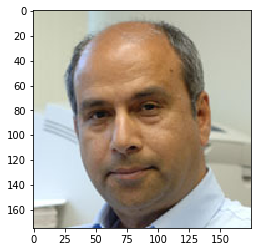

In [4]:
shah = np.array(Image.open("Data/Dr_Shah.jpg"))
shah = shah[:175,25:200]
plt.imshow(shah)
print(shah.shape)

(244, 244, 3)


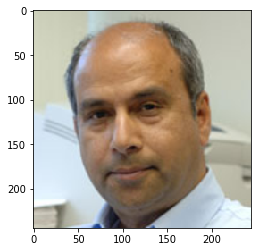

In [5]:
shah = Image.fromarray(shah)
shah = shah.resize((244,244),Image.BILINEAR)
shah = np.array(shah)
plt.imshow(shah)
print(shah.shape)

(698, 1586, 3)


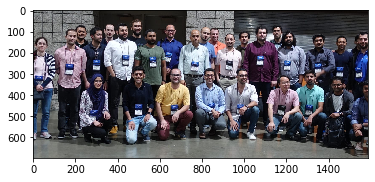

In [6]:
target = Image.open("Data/cvpr2019.jpg")
target = np.array(target)
print(target.shape)
plt.imshow(target)

(80, 80, 3)


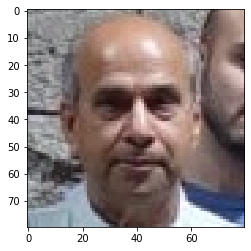

In [7]:
ex = target[90:170,730:810]
plt.imshow(ex)
print(ex.shape)

(2100, 4800, 3)


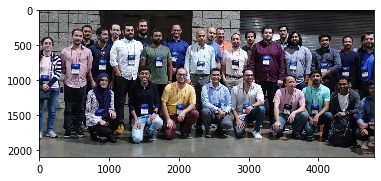

In [8]:
# Resizing up, factor of 3. 2100,4800. 
target = Image.open("Data/cvpr2019.jpg")
target = target.resize((4800,2100),Image.BILINEAR)
target = np.array(target)
print(target.shape)
plt.imshow(target)

(244, 244, 3)


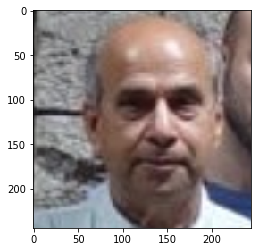

In [9]:
ex = target[270:514,2190:2434]
plt.imshow(ex)
print(ex.shape)

In [10]:
feat_gen = nn.Sequential(*list(model.children())[:-4])

In [15]:
face_features   = FeatureGeneration(feat_gen,[[shah]])
search_features = FeatureGeneration(feat_gen,[[target]])

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 8.00 GiB total capacity; 6.20 GiB already allocated; 18.65 MiB free; 18.54 MiB cached)